# Debye scattering equation (1/2)
This notebook computes the scattered intensity from arbitrary atomic ensembles using the Debye scattering equation:
$$ I \left( Q \right) = \sum_{i=1}^{N}\sum_{j=1}^{N}f_i(Q) f_j(Q) {sin \left(Q r_{ij} \right) \over {Q r_{ij}}}$$
The result is "powder diffraction"-like pattern. The first step of the computation consist in calculating all atomic pair distances $r_{ij}$. The second step in the summation over all values of $r_{ij}$.
For a monoatomic crystal the equation can be written:
$$ I \left( Q \right) = \left| f(Q) \right|^2  \left[ N + 2 \sum_{i=1}^{N}\sum_{j>i}^{N}{sin \left(Q r_{ij} \right) \over {Q r_{ij}}}  \right] $$
For a multi-element crystal this equation simply has to be evaluated for all homo-atomic pairs and all hetero-atomic pairs in the crystal.

Load external libraries.

In [1]:
import math
import numpy as np
import numexpr as ne
import numba as nb
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import os
n_cpu = os.cpu_count()

Now we load the atomic coordinates and the coefficients required for the calculation of the atomic scattering factor. The first 11 elements of the coeff array are the coefficients given by [Waasmaier & Kirfel](https://doi.org/10.1107/S0108767394013292) for each element of the periodic table. The last element is the absorption/anomalous dispersion coefficient as given in the [Brennan-Cowan database](https://doi.org/10.1063/1.1142625).

In [2]:
# Atomic coordinates within cluster
coords = np.loadtxt("Au.xyz")
# Atomic scattering factor coefficients
coeff = np.array([16.777390,19.317156,32.979683,5.595453,10.576854,-6.279078,0.122737,
                  8.621570,1.256902,38.008820,0.000601, -4.014837862516359+7.717066375953113j])
# Define 2theta computation range
tth = np.arange(10, 180, 0.2)*np.pi/180
# X-ray wavelength
wl = 1.5406
# Step (in Angstroms) to compute the distance histogram
step=0.0005

Global variables computed from the above

In [3]:
N, dim = np.shape(coords) #Extract the number of atoms and the number of dimensions
Q = 4*np.pi*np.sin(tth/2) / wl #Compute the scatttering vector range

# Part 1: computing pairwise distances

## Pure python implementation

In [4]:
def r_ij_python(coords):
    r = [0 for x in range(int((N*N-N)/2))]
    l = 0
    for i in range(N):
        for j in range(i+1,N):
            tmp = 0
            for k in range(dim):
                tmp += (coords[i,k]-coords[j,k])**2
            r[l] = tmp**0.5
            l += 1
    return np.array(r)

%time r_ij_py = r_ij_python(coords)

CPU times: user 25.3 s, sys: 411 ms, total: 25.7 s
Wall time: 25.7 s


## Numpy implementation

In [6]:
def r_ij_numpy(coords):
    r = np.dot(coords, coords.T)
    m = np.tile(np.diag(r), (N,1))
    r = np.sqrt(m + m.T - 2*r)
    r = np.triu(r).ravel() #Take the upper triangular matrix and reshape to 1D array
    return r[np.nonzero(r)]
%timeit r_ij_numpy(coords)
r_ij_np = r_ij_numpy(coords)
print("Is the result correct:",np.allclose(r_ij_py, r_ij_np)) 

1 loop, best of 3: 1.42 s per loop
Is the result correct: True


## NumExpr implementation

In [7]:
def r_ij_numexpr(coords):
    r = np.dot(coords, coords.T)
    m = np.tile(np.diag(r), (N,1))
    mT = m.T
    ne.set_num_threads(n_cpu)
    r = ne.evaluate("sqrt(m + mT - 2*r)")
    r = np.triu(r).ravel() #Take the upper triangular matrix and reshape to 1D array
    return r[np.nonzero(r)]
%timeit r_ij_numexpr(coords)
r_ij_ne = r_ij_numexpr(coords)
print("Is the result correct:",np.allclose(r_ij_py, r_ij_ne))

1 loop, best of 3: 821 ms per loop
Is the result correct: True


## SciPy implementation 

In [8]:
r_ij_sp = pdist(coords, metric='euclidean')
%timeit pdist(coords, metric='euclidean')
print("Is the result correct:",np.allclose(r_ij_py, r_ij_sp))

10 loops, best of 3: 72.1 ms per loop
Is the result correct: True


## Numba implementation

In [9]:
@nb.jit(nb.float64[:](nb.float64[:,:]), nopython=True, fastmath=True, parallel=True)
def r_ij_numba(coords):
    r = np.zeros(int((N*N-N)/2), dtype=nb.float64)
    for i in nb.prange(N):
        for j in range(i+1,N):
            l = int(i * (N - 1) - i * (i + 1) / 2 + j - 1)
            tmp = 0.0
            for k in range(dim):
                tmp += (coords[i,k]-coords[j,k])**2
            r[l] = tmp**0.5
    return r

%timeit r_ij_numba(coords)
r_ij_nb = r_ij_numba(coords)
print("Is the result correct:",np.allclose(r_ij_py, r_ij_nb))

100 loops, best of 3: 15.7 ms per loop
Is the result correct: True


## Pythran implementation

In [10]:
%load_ext pythran.magic

In [11]:
%%pythran -fopenmp

#pythran export r_ij_pythran(float[][])
import numpy as np

def r_ij_pythran(coords):
    N, dim = np.shape(coords)
    r = np.zeros(int((N*N-N)/2), dtype=np.float64)
    "omp parallel for"
    for i in range(N):
        for j in range(i+1,N):
            l = i * (N - 1) - i * (i + 1) / 2 + j - 1
            tmp = 0.0
            for k in range(dim):
                tmp += (coords[i,k]-coords[j,k])**2
            r[l] = np.sqrt(tmp)
    return r

In [12]:
%timeit r_ij_pythran(coords)
r_ij_pt = r_ij_pythran(coords)
print("Is the result correct:",np.allclose(r_ij_py, r_ij_pt))

100 loops, best of 3: 11.1 ms per loop
Is the result correct: True


## Cython implementation

In [13]:
%load_ext Cython

In [14]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

cimport numpy as cnp
from libc.math cimport sqrt

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def r_ij_cython(double[:,::1] coords):
    cdef:
        double[::1] r
        double tmp
        cnp.int64_t i,j,k,l
        cnp.int64_t N = coords.shape[0]
        cnp.int64_t dim = coords.shape[1]
    
    r = np.zeros(int((N*N-N)/2), dtype=np.float64)
    for i in prange(N, nogil=True):
        for j in range(i+1,N):
            l = int(i * (N - 1) - i * (i + 1) / 2 + j - 1)
            tmp = 0.0
            for k in range(dim):
                tmp = tmp + (coords[i,k]-coords[j,k])**2
            r[l] = sqrt(tmp)
    return r

In [15]:
%timeit r_ij_cython(coords)
r_ij_ct = np.asarray(r_ij_cython(coords))
print("Is the result correct:",np.allclose(r_ij_py, r_ij_ct))

100 loops, best of 3: 13 ms per loop
Is the result correct: True


# Part 2: perform the summation over $r_{ij}$

First compute the atomic scattering factor

In [16]:
def asf(th,wl,coeff):
    n = 0
    sum = coeff[5]
    while n <= 4:
        sum = sum + coeff[n] * np.exp ( -coeff[n+6] * ( np.sin(th) / wl )**2)
        n = n+1
    return sum + coeff[-1]
f_at = asf(tth/2, wl, coeff)

## Python implementation

In [17]:
def Debye_python(Q,r,N,f_at):
    res = [0 for i in range(int(len(Q)))]
    for i_Q, v_Q in enumerate(Q):
        tmp = 0.0
        for v_r in r:
            tmp += math.sin(v_Q*v_r)/(v_Q*v_r)
        res[i_Q] = (N + 2*tmp)*abs(f_at[i_Q])**2
    return np.array(res)
%time ref_intensity = Debye_python(Q,r_ij_nb,N,f_at)

CPU times: user 52min 42s, sys: 4.64 s, total: 52min 47s
Wall time: 52min 47s


<IPython.core.display.Javascript object>


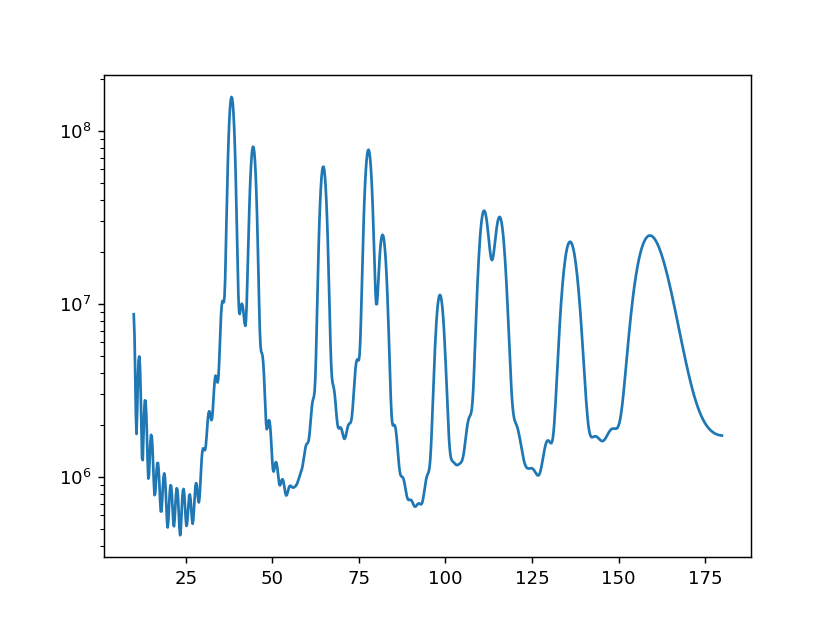

In [18]:
np.savetxt("ref_intensity.txt", ref_intensity, fmt='%10.8f') #save the file for use with histogram notebook
%matplotlib notebook
plt.semilogy(tth*180/np.pi, ref_intensity)
plt.show()

## Numpy implementation

In [19]:
def Debye_numpy(Q,r,N,f_at):
    r = r[np.newaxis, :]
    Q = Q[:,np.newaxis]
    res = abs(f_at)**2 * (N + 2*((np.sin(Q*r)/(Q*r)).sum(axis=1)))
    return res

%timeit Debye_numpy(Q,r_ij_nb,N,f_at)
intensity_np = Debye_numpy(Q,r_ij_nb,N,f_at)
print("Error:", abs(intensity_np-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 7min 53s per loop
Error: 1.34677609602e-11


## NumExpr  implementation

In [20]:
def Debye_numexpr(Q,r,N,f_at):
    r = r[np.newaxis, :]
    Q = Q[:,np.newaxis]
    ne.set_num_threads(n_cpu)
    res = ne.evaluate("2*sin(Q*r)/(Q*r)") #This must be evaluated before the sum to benefit from multi-threading
    res = ne.evaluate("sum((res), axis=1)")
    res = ne.evaluate("(N + res)*(real(f_at)**2 + imag(f_at)**2)") 
    return res

%timeit Debye_numexpr(Q,r_ij_nb,N,f_at)
intensity_ne = Debye_numexpr(Q,r_ij_nb,N,f_at)
print("Error:", abs(intensity_ne-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 46.2 s per loop
Error: 1.89292193177e-16


## Numba implementation

In [21]:
@nb.jit(nb.float64[:](nb.float64[:], nb.float64[:], nb.int64, nb.complex128[:]),
        nopython=True, fastmath=True, parallel=True)
def Debye_numba(Q,r,N,f_at):
    res = np.zeros(int(len(Q)), dtype = nb.float64)
    for i_Q in nb.prange(len(Q)):
        tmp = 0.0
        for i_r in range(len(r)): #"for v_r in r" doens't work (probably bc r is float)
            tmp += math.sin(Q[i_Q]*r[i_r])/(Q[i_Q]*r[i_r])
        res[i_Q] = (N + 2*tmp)*abs(f_at[i_Q])**2
    return res

%timeit Debye_numba(Q,r_ij_nb,N,f_at)
intensity_nb = Debye_numba(Q,r_ij_nb,N,f_at)
print("Error:", abs(intensity_nb-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 18.5 s per loop
Error: 1.41969144883e-16


## Pythran implementation 

In [22]:
%reload_ext pythran.magic

In [23]:
%%pythran -fopenmp

#pythran export Debye_pythran(float[], float[], int, complex[])
import numpy as np

def Debye_pythran(Q,r,N,f_at):
    res = np.zeros(int(len(Q)), dtype = np.float64)
    "omp parallel for"
    for i_Q in range(len(Q)):
        tmp = 0.0
        for i_r in range(len(r)):
            tmp += np.sin(Q[i_Q]*r[i_r])/(Q[i_Q]*r[i_r])
        res[i_Q] = (N + 2*tmp)*abs(f_at[i_Q])**2
    return res

In [24]:
%timeit Debye_pythran(Q,r_ij_pt,N,f_at)
intensity_pt = Debye_pythran(Q,r_ij_pt,N,f_at)
print("Error:", abs(intensity_pt-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 5.77 s per loop
Error: 1.89292193177e-16


## Cython implementation

In [25]:
%reload_ext Cython

In [26]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
import math
from cython.parallel import prange
import cython

from libc.math cimport sin
#cdef extern from "math.h" nogil:
#    double sin(double x)
    
cdef extern from "complex.h" nogil:
    double cabs(double complex)

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def Debye_cython(double[::1] Q, double[::1] r, long N, double complex[::1] f_at):
    cdef:
        double tmp
        long i_r, i_Q, size_r, size_Q
        double[::1] res
    
    size_r = r.size
    size_Q = Q.size
    res = np.zeros((size_Q))
    for i_Q in prange(size_Q, nogil=True):
        tmp = 0.0
        for i_r in range(size_r):
            tmp = tmp + sin(Q[i_Q]*r[i_r])/(Q[i_Q]*r[i_r])
        res[i_Q] = (N + 2*tmp)*cabs(f_at[i_Q])**2
    return res

In [27]:
%timeit Debye_cython(Q,r_ij_pt,N,f_at)
intensity_ct = Debye_cython(Q,r_ij_pt,N,f_at)
print("Error:", abs(intensity_ct-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 5.77 s per loop
Error: 1.41969144883e-16
